In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import SimpleITK as sitk


def plot_overlay_bboxes(img1, img2, title):
    class_colors = {
        2: [0, 1, 0],
        1: [0, 0, 1],
        3: [1, 0, 0],
    }
    img1_rgb = np.stack((img1, img1, img1), axis=-1)

    for class_label, color in class_colors.items():
        mask = (img2 == class_label).astype(np.uint8)
        contour_color = (
            color[0] * 255,
            color[1] * 255,
            color[2] * 255,
        )  # Convert color for contour (BGR)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            # Draw bounding box in the same color
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(
                img1_rgb, (x, y), (x + w, y + h), contour_color, 2
            )  # Bounding box

        # Apply color overlay with half opacity for mask
        overlay = np.zeros_like(img1_rgb)
        overlay[mask == 1] = np.array(color) * 255  # Overlay expects color in [0, 255]
        img1_rgb[mask == 1] = (
            img1_rgb[mask == 1] * 0.5 + overlay[mask == 1] * 0.5
        ).astype(np.uint8)

    img1_rgb = np.clip(
        img1_rgb, 0, 255
    )  # Ensure the pixel values are valid after overlay

    plt.imshow(
        cv2.cvtColor(img1_rgb, cv2.COLOR_BGR2RGB)
    )  # Convert BGR to RGB for displaying
    plt.title(title)
    plt.axis("off")
    plt.show()


def plot_segmentation_with_bboxes(patient_id):
    ROOT = "/home/venom/Downloads/CAMUS_public/database_nifti/"
    subfolder = f"patient0{patient_id:03d}"

    original_files = [
        "2CH_ED",
        "2CH_ES",
        # "2CH_half_sequence",
        "4CH_ED",
        "4CH_ES",
        # "4CH_half_sequence",
    ]

    for ori_file in original_files:
        path1 = os.path.join(ROOT, subfolder, f"{subfolder}_{ori_file}.nii.gz")
        if not os.path.isfile(path1):
            print(f"Original file not found: {path1}")
            continue

        img1 = sitk.GetArrayFromImage(sitk.ReadImage(path1))
        img1 = (
            img1.astype(np.float32) / img1.max()
        )  # Normalize the original image to the range [0, 1]

        gt_file = ori_file + "_gt"
        path2 = os.path.join(ROOT, subfolder, f"{subfolder}_{gt_file}.nii.gz")

        if os.path.isfile(path2):
            img2 = sitk.GetArrayFromImage(sitk.ReadImage(path2))
            plot_overlay_bboxes(img1, img2, f"{ori_file} with {gt_file}")
        else:
            print(f"Corresponding segmentation file not found: {path2}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


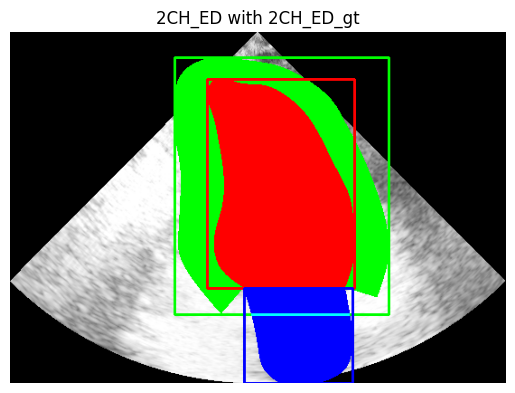

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


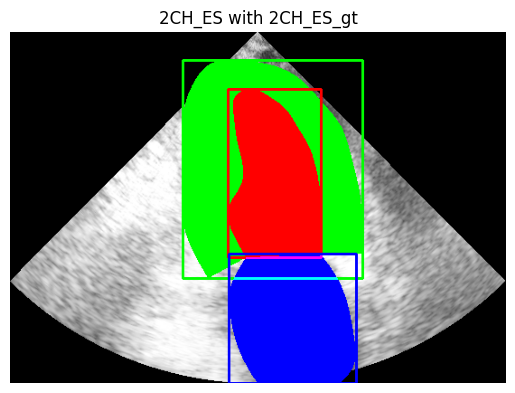

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


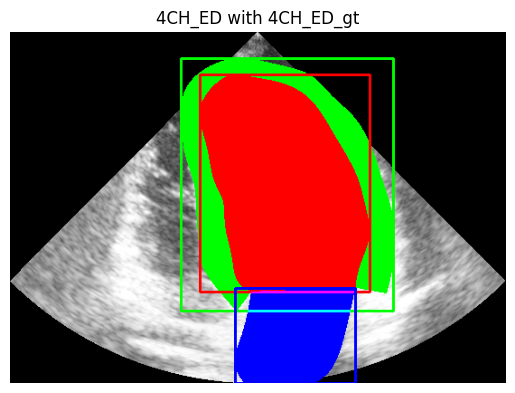

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


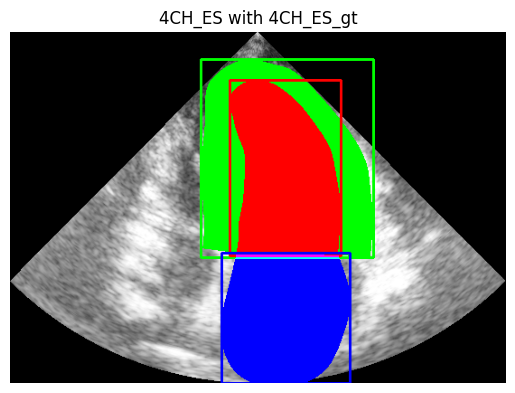

In [14]:
plot_segmentation_with_bboxes(1)

In [5]:
import os
import cv2
import numpy as np
from skimage import io
import SimpleITK as sitk
from tqdm import tqdm


def export_yolo_data(
    patient_id, image_export_folder, annotations_export_folder, root_folder
):
    subfolder = f"patient0{patient_id:03d}"

    original_files = [
        "2CH_ED",
        "2CH_ES",
        # "2CH_half_sequence",
        "4CH_ED",
        "4CH_ES",
        # "4CH_half_sequence",
    ]

    for ori_file in original_files:
        path1 = os.path.join(root_folder, subfolder, f"{subfolder}_{ori_file}.nii.gz")
        if not os.path.isfile(path1):
            print(f"Original file not found: {path1}")
            continue

        img1 = sitk.GetArrayFromImage(sitk.ReadImage(path1))
        img1 = (
            img1.astype(np.float32) / img1.max()
        )  # Normalize the original image to the range [0, 1]

        gt_file = ori_file + "_gt"
        path2 = os.path.join(root_folder, subfolder, f"{subfolder}_{gt_file}.nii.gz")

        if os.path.isfile(path2):
            img2 = sitk.GetArrayFromImage(sitk.ReadImage(path2))

            # Save the image as a JPEG file
            img_filename = f"{subfolder}_{ori_file}.jpeg"
            img_output_path = os.path.join(image_export_folder, img_filename)
            plt.imsave(img_output_path, img1, cmap="gray")

            # Save the bounding box annotations in a text file
            img_height, img_width = img1.shape
            class_labels = np.unique(img2)

            with open(
                os.path.join(annotations_export_folder, f"{subfolder}_{ori_file}.txt"),
                "w",
            ) as f:
                for class_label in class_labels:
                    class_label = int(class_label)
                    if class_label == 0:  # Ignore the background class
                        continue

                    binary_mask = np.zeros_like(img2)
                    binary_mask[img2 == class_label] = 1

                    contours, _ = cv2.findContours(
                        binary_mask.astype(np.uint8),
                        cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE,
                    )

                    for contour in contours:
                        x, y, w, h = cv2.boundingRect(contour)
                        f.write(
                            f"{class_label - 1} {(x + w / 2) / img_width} {(y + h / 2) / img_height} {w / img_width} {h / img_height}\n"
                        )
        else:
            print(f"Corresponding segmentation file not found: {path2}")


In [6]:
image_export_folder = "./out/train/images"
annotations_export_folder = "./out/train/labels"
root_folder = "/home/venom/Downloads/CAMUS_public/database_nifti/"

# Check if the specified folders exist and create them if they don't
os.makedirs(image_export_folder, exist_ok=True)
os.makedirs(annotations_export_folder, exist_ok=True)

# Number of patients
n_patients = 450

# Call the export_yolo_data function for each patient ID and use tqdm to show progress
for patient_id in tqdm(range(1, n_patients + 1)):
    export_yolo_data(
        patient_id, image_export_folder, annotations_export_folder, root_folder
    )


100%|██████████| 450/450 [00:36<00:00, 12.42it/s]


In [7]:
image_export_folder = "./out/val/images"
annotations_export_folder = "./out/val/labels"
root_folder = "/home/venom/Downloads/CAMUS_public/database_nifti/"

# Check if the specified folders exist and create them if they don't
os.makedirs(image_export_folder, exist_ok=True)
os.makedirs(annotations_export_folder, exist_ok=True)

# Number of patients
n_patients = 500

# Call the export_yolo_data function for each patient ID and use tqdm to show progress
for patient_id in tqdm(range(451, n_patients + 1)):
    export_yolo_data(
        patient_id, image_export_folder, annotations_export_folder, root_folder
    )


100%|██████████| 50/50 [00:04<00:00, 11.12it/s]
